## Advanced Numerical  Methods in Many-Body Physics
# Exercise 4
### Jesse Hoogland 

--- 
Note: most of the actual computational logic is in the file `metropolis_hastings.py` included in this folder.

## Imports

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metropolis_hastings import *  

# 4.1 Monte Carlo 2D Ising Model
$$L=4$$ 
$$T=3\iff J=1/3$$ 
 
I used $2^{14} $ sampling steps with $1000$ burn-in/thermalization steps and $1$ step per sweep (i.e. no steps between samples). 

In [2]:
 # I used J, the inverse temperature throughout my code (hence 1/3.)
     
# This object represents the lattice and implemenents its underlying dynamics
ising_model = IsingModel2D(lattice_width=4, J=1./3.) 

# This object, the sampler, is oblivious to the underlying dynamics,
# and it stores the samples generated by a given lattice model
sampler = SamplerMCMC(ising_model, n_samples=2**14)

# Here, we run the markov chain and generate the samples
sampler.run_MCMC(n_thermalization_steps=1000, n_steps_between_samples=0)

Thermalizing
Generating samples


array([[[ 1.,  1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1.,  1.],
        [ 1., -1., -1.,  1.]],

       [[ 1.,  1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1.,  1.],
        [ 1., -1., -1., -1.]],

       [[ 1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1.,  1.],
        [ 1., -1., -1., -1.]],

       ...,

       [[-1.,  1., -1., -1.],
        [-1., -1., -1., -1.],
        [ 1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1.,  1.,  1., -1.],
        [-1., -1., -1., -1.],
        [ 1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[ 1.,  1.,  1., -1.],
        [-1., -1., -1., -1.],
        [ 1., -1., -1., -1.],
        [-1., -1., -1., -1.]]])

In [3]:
def exercise_1(): 
    # To avoid namespace errors, I've grouped the calculations for each exercise
    # under a function.
    
    # The SamplerMCMC object has a method `get_expectation` which takes a function that calculates
    # an observable over one sample and averages it over all samples.

    # Furthermore, this method provides an error estimate through a binning analysis
    # if the flag `include_error` is passed.
    energy, energy_error = sampler.get_expectation(get_energy, include_error=True)
    magnetization, magnetization_error = sampler.get_expectation(get_magnetization, include_error=True)
    order_param, order_param_error = sampler.get_expectation(get_order_param, include_error=True)
    magnetization_squared, magnetization_squared_error = sampler.get_expectation(get_magnetization_squared, include_error=True)
    
    print("Energy: {} ± {}".format(energy, energy_error))
    print("Magnetization: {} ± {}".format(magnetization, magnetization_error))
    print("Order Parameter (Absolute Magnetization): {} ± {}".format(order_param, order_param_error))
    print("Magnetization Squared: {} ± {}".format(magnetization_squared, magnetization_squared_error))
    
exercise_1()

Energy: -1.01229858398 ± 0.0286603735377
Magnetization: 0.0256423950195 ± 0.0655105873252
Order Parameter (Absolute Magnetization): 0.596290588379 ± 0.017767015697
Magnetization Squared: 114.254638672 ± 4.76495522342


We see that for each of the expectation values here, the given reference value is within 1 standard deviation. At first, I thought the error for the magnetization squared was quite high, but in relative terms, my error bars are consistently about two orders of magnitude larger than for the reference value. With more samples, this would obviously come down.

For the binning error analysis, I assumed that the error converged within 11 steps and simply took the error left after 11 steps. I could have taken as much as 14 binning steps, but from my experience with the previous assignment, I knew that there would be too much variability with such small numbers of bins to use these as accurate gauges of error. To check whether this convergence assumption was true, I plotted the binning error as it varies with bins (as is in the previous assignment).  From the following graph, we see that error had indeed saturated within 8 and 11 steps and that the variability increased dramatically beyond this point.

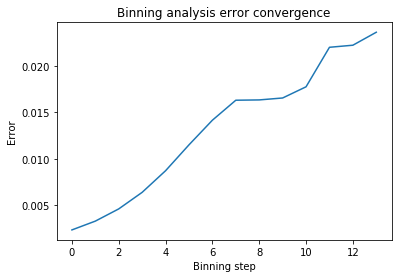

In [4]:
def test_convergence_assumption():
    # I could have taken any of the observables, but I decided to use the
    # order parameter as a representative example
    order_param_measurements = sampler.get_measurements(get_order_param)
    plt.plot(sampler.binning_analysis(order_param_measurements, stop_n_before=0))
    plt.xlabel('Binning step')
    plt.ylabel('Error')
    plt.title('Binning analysis error convergence')

test_convergence_assumption()
    

# 4.2 Varying Temperatures and System Sizes

In [5]:
SYSTEM_WIDTHS = [4, 8, 12, 16, 24] 
TEMPERATURES = [0.1, 0.5, 1., 1.5, 2, 2.25, 2.5, 2.75, 3, 3.5, 4, 4.5, 5]
#[0.5, 1.5, 2.25, 2.75, 3.5, 4.5, 5] #[0.1, 1., 2, 2.5, 3, 4, 10]
# 

INVERSE_TEMPERATURES = [1./ t for t in TEMPERATURES]

In [ ]:
def gen_mcmc_datasets():
    
    for L in SYSTEM_WIDTHS:
        print("L = {}".format(L))
        ising_model = IsingModel2D(L, INVERSE_TEMPERATURES[0])
        sampler = SamplerMCMC(ising_model, 2**14)

        for J in INVERSE_TEMPERATURES:
            print("J = {}".format(J))
            ising_model.set_J(J)
            sampler.run_MCMC(n_thermalization_steps=1000, n_steps_between_samples=L**2)
            sampler.save_samples()
            
gen_mcmc_datasets()

## 4.2.1

L=4
L=8
L=12
L=16
L=24


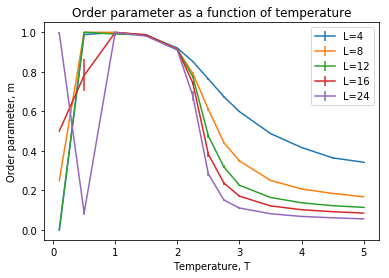

In [9]:
def exercise_4_2_1():
    results = {}
    fig = plt.figure()

    for L in SYSTEM_WIDTHS:
        print("L={}".format(L))
        ising_model = IsingModel2D(L, INVERSE_TEMPERATURES[0])
        sampler = SamplerMCMC(ising_model, 2**14)

        order_params = np.zeros((len(INVERSE_TEMPERATURES)))
        order_param_errors = np.zeros((len(INVERSE_TEMPERATURES)))
        
        for i, J in enumerate(INVERSE_TEMPERATURES):
            ising_model.set_J(J)
            sampler.load_samples() 
            order_params[i], order_param_errors[i] = sampler.get_expectation(get_order_param)
                
        plt.errorbar(TEMPERATURES, order_params, yerr=order_param_errors, label="L={}".format(L)) 
       
    plt.title("Order parameter as a function of temperature")
    plt.xlabel("Temperature, T")
    plt.ylabel("Order parameter, m")
    plt.legend()
    plt.show() 
        
exercise_4_2_1()

Especially above the critical temperature, we notice the finite size effects. As we increase the lattice size, the order parameter as a function of temperature comes closer and closer to a curve with a "kink" at the critical temperature (where the second derivative vanishes). We notice in this region that the error bars are quite small compared to the total magnitude of the order parameter, and that the opposite holds near 0 temperature: the error kills the shape of the curve (from physical intuition we know all curves should go to $1$ as temperature goes to $0$

## 4.2.2

L=4
L=8
L=12
L=16
L=24


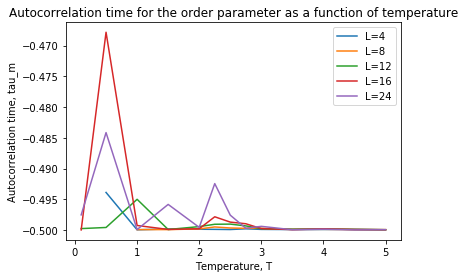

In [10]:
def exercise_4_2_2():
    results = {}
    fig = plt.figure()

    for L in SYSTEM_WIDTHS:
        print("L={}".format(L))
        ising_model = IsingModel2D(L, INVERSE_TEMPERATURES[0])
        sampler = SamplerMCMC(ising_model, 2**14)

        corr_times = np.zeros((len(INVERSE_TEMPERATURES)))
        
        for i, J in enumerate(INVERSE_TEMPERATURES):
            ising_model.set_J(J)
            sampler.load_samples() 
            corr_times[i] = sampler.get_correlation_times(get_order_param)
                
        plt.plot(TEMPERATURES, corr_times, label="L={}".format(L)) 
        
    plt.title("Autocorrelation time for the order parameter as a function of temperature")
    plt.xlabel("Temperature, T")
    plt.ylabel("Autocorrelation time, tau_m")
    plt.legend()
    plt.show() 
        
exercise_4_2_2()

This confirms what we already observed in the previous exercise, that the low-temperature samples are less reliable.

Moreover, we see that the low-temperature samples become less reliable (i.e. representative of the full state space) as we increase the system size. Physically, we understand that the larger systems are more "stuck" in a given sector, because it requires more spins to coincidentally fluctuate in the right way to overcome the 50% threshold and change to the new sector.


## 4.2.3

L=4
L=8
L=12
L=16
L=24


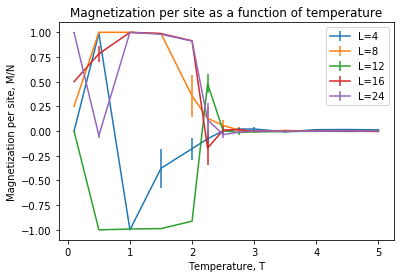

In [11]:
def exercise_4_2_3():
    results = {}
    fig = plt.figure()

    for L in SYSTEM_WIDTHS:
        print("L={}".format(L))
        ising_model = IsingModel2D(L, INVERSE_TEMPERATURES[0])
        sampler = SamplerMCMC(ising_model, 2**14)

        order_params = np.zeros((len(INVERSE_TEMPERATURES)))
        order_param_errors = np.zeros((len(INVERSE_TEMPERATURES)))
        
        for i, J in enumerate(INVERSE_TEMPERATURES):
            ising_model.set_J(J)
            sampler.load_samples() 
            order_params[i], order_param_errors[i] = sampler.get_expectation(get_magnetization)
                
        plt.errorbar(TEMPERATURES, order_params, yerr=order_param_errors, label="L={}".format(L)) 
        
    plt.title("Magnetization per site as a function of temperature")
    plt.xlabel("Temperature, T")
    plt.ylabel("Magnetization per site, M/N")
    plt.legend()
    plt.show() 
        
exercise_4_2_3()

This suggests that we shouldn't trust the samples below the critical temperature. The Ising system as a sign-flip symmetry, so for each state with a given magnetization, $M$, there is an equally likely state with the opposite magnetization, $-M$. Therefore, everywhere (above AND below the critical temperature) we expect the expectation of the magnetization to be $0$. As we see, this is not the case here. Because we are looking at single Markov chains, there is a significant amount of correlation within each chain: each chain gets stuck in a sector with a very small probability of exiting. To circumvent this kind of problem, we might initialize several different chains at the same time, and average over these as well. Then, we might hope that different chains get stuck in different sectors.


# 4.3 Heat-bath Algorithm 
We want to show that detailed balance holds, i.e. $P_f P_{f\rightarrow i} = P_i P_{i\rightarrow f}$ . Reorganizing, we get:
$$ \frac{P_i}{P_f}= \frac{P_{f\rightarrow i}}{P_{i\rightarrow f}}.$$

For the left-hand-side, we have, $$\frac{P_i}{P_f}= e^{\beta \Delta E},$$ where $\Delta E = E_f-E_i$. This is because, in relative probabilities, the partition functions cancel out and the result only depends on the difference in energies.  

We are given that
$$p_{i\rightarrow f}= \frac{e^{-\beta \Delta E}}{1+e^{-\beta \Delta E}},$$
written as $p_\text{accept}$ in the problem description. Then, by the definition of $\Delta E$, we know
$$p_{f\rightarrow i}= \frac{e^{\beta \Delta E}}{1+e^{\beta \Delta E}}.$$

Let's evaluate the right-hand-side in full:
$$\frac{P_{f\rightarrow i}}{P_{i\rightarrow f}}=\frac{e^{\beta \Delta E}}{1+e^{\beta \Delta E}} \left(\frac{e^{-\beta \Delta E}}{1+e^{-\beta \Delta E}}\right)^{-1}=e^{\beta \Delta E} \frac{1+e^{-\beta \Delta E}}{e^{-\beta \Delta E}(1+e^{\beta \Delta E})} = e^{\beta \Delta E},$$
which is what we have on the left-hand-side. Therefore, the heat-bath algorithm obeys detailed balance.